In [2]:
%load_ext autoreload
%autoreload 2
from evaluation_scripts.experiment_class import Experiment
from evaluation_scripts.statistics import summarize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import matplotlib.patches as mpatch
from evaluation_scripts.oneway import OneWaySignificance
from figures import Figure, generate_style
from functools import reduce

dates = ["20210417", "20220127", "20220412"]
labels = ["U_mean", "single_resistant_mean", "double_resistant_mean"]
dt = 4
linewidth = 4

style = generate_style(
    fontsize=25, frontcolor="black", backcolor="white", frame="box", use_latex = False
)

#style = Style("white", fontsize = 20)
figure = Figure(style)
figure.add_folder("/Users/malte/ETH-Documents/TSP-Collection/TSPlasmids_main/summary")
palette = sns.color_palette("colorblind")
set2 = sns.color_palette("Set2")
colors = [set2[-1], palette[0], "#03C03C"]
color_dict = dict(zip(labels, colors))
palette

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## Summerize Data

In [3]:
dfs = []
significance_dict = {}
for date in dates:
    print("\n", date)
    exp = Experiment(date)
    Data = exp.data
    
    Data["single_resistant"] = (Data.phenotype.isin(["A_r", "B_r", "A&B"]))
    Data["resistant"] = (Data.phenotype.isin(["A_r", "B_r", "A&B", "AB_r"]))
    Data["U"] = (Data.phenotype == "U")
    Data["double_resistant"] = (Data.phenotype == "AB_r")
    t_max = max(Data.transfer_n)
    Data_end = Data[Data.transfer_n > t_max-dt]
    cols = ["strategy", "transfer_n", "rep", "single_resistant", "U", "double_resistant", "resistant"]
    Data_end = Data_end[cols]
    groups = ["strategy", "rep"]
    
    group_col = "strategy"
    
    summary_u = summarize(Data_end, groups, "U")
    summary_res = summarize(Data_end, groups, "single_resistant")
    summary_ab = summarize(Data_end, groups, "double_resistant")
    summaries = [summary_u, summary_res, summary_ab]
    
    merged_df = reduce(lambda left, right: pd.merge(left, right, on=['strategy', 'rep']), summaries)
    df = pd.melt(merged_df, id_vars=['strategy', 'rep'], 
                           value_vars=["U_mean", "single_resistant_mean", "double_resistant_mean"],
                           var_name='label', value_name='value')
    df["date"] = date
    dfs.append(df)
    sub_dict = {}
    for summary, label in zip(summaries, labels):
        print(label)
        significance = OneWaySignificance(summary, "strategy", summary.columns[-1])
        #significance.plot(dot_color = color,  order = exp.strategies, jitter =.1, violin = False, bar_color = color, strip = False, ax = ax, dx = dx)
        l = label.split("_")[0]
        significance.write_anova_results(os.path.join(exp.pathes["tables"], exp.exp +l + "_anova.tex"))
        sub_dict.update({label:significance})

    significance_dict.update({date:sub_dict})
summary_df = pd.concat(dfs)


 20210417
U_mean
single_resistant_mean
double_resistant_mean

 20220127
U_mean
single_resistant_mean
double_resistant_mean

 20220412
U_mean
single_resistant_mean
double_resistant_mean


In [4]:
# Function to retrieve the letter from the significance_dict
def get_letter(row):
    date = row.name[0]
    strategy = row.name[1]
    label = row.name[2]
    
    # Accessing the nested significance_dict
    subplot_info = significance_dict[date]
    significance_summary = subplot_info[label]
    if significance_summary.anova_pvalue < .05:
        letter = significance_summary.letters.loc[strategy].values[0]
    else:
        letter = None
    return letter

grouped_df = summary_df[["date", "strategy", "label", "value"]].groupby(["date", "strategy", "label"]).max()
grouped_df['letters'] = grouped_df.apply(get_letter, axis=1)
grouped_df_mean = summary_df[["date", "strategy", "label", "value"]].groupby(["date", "strategy", "label"]).mean()
grouped_df["mean"] = grouped_df_mean["value"]

In [5]:
grouped_df.letters.fillna("a", inplace = True)

In [30]:
import matplotlib.pyplot as plt

def add_panel_letter(ax, letter, fontsize, fontfamily, x_offset=-.5, y_offset=0.0, weight='bold'):
    # Get title position and adjust for alignment with the panel letter
    title = ax.get_title()
    title_position = ax.title.get_position()
    
    # Set the position for the panel letter
    ax.text(
        title_position[0] + x_offset, title_position[1] + y_offset, letter,
        transform=ax.transAxes,
        fontsize=fontsize,
        fontfamily = fontfamily,
        fontweight=weight,
        va='bottom',
        ha='right'
    )

/opt/anaconda3/envs/tsp_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/f7/ks4rl3915yj6crhznly5p28h0000gq/T/ipykernel_11084/3873225684.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[2, 0].set_xticklabels(xticks)
/var/folders/f7/ks4rl3915yj6crhznly5p28h0000gq/T/ipykernel_11084/3873225684.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)
/var/folders/f7/ks4rl3915yj6crhznly5p28h0000gq/T/ipykernel_11084/3873225684.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)
/var/folders/f7/ks4rl3915yj6crhznly5p28h0000gq/T/ipykernel_11084/3873225684.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)
/var/folders/f7/ks4rl3915yj6crhznly5p28h0000gq/T/ipy

Figure saved at /Users/malte/ETH-Documents/TSP-Collection/TSPlasmids_main/summary/end_anova.pdf


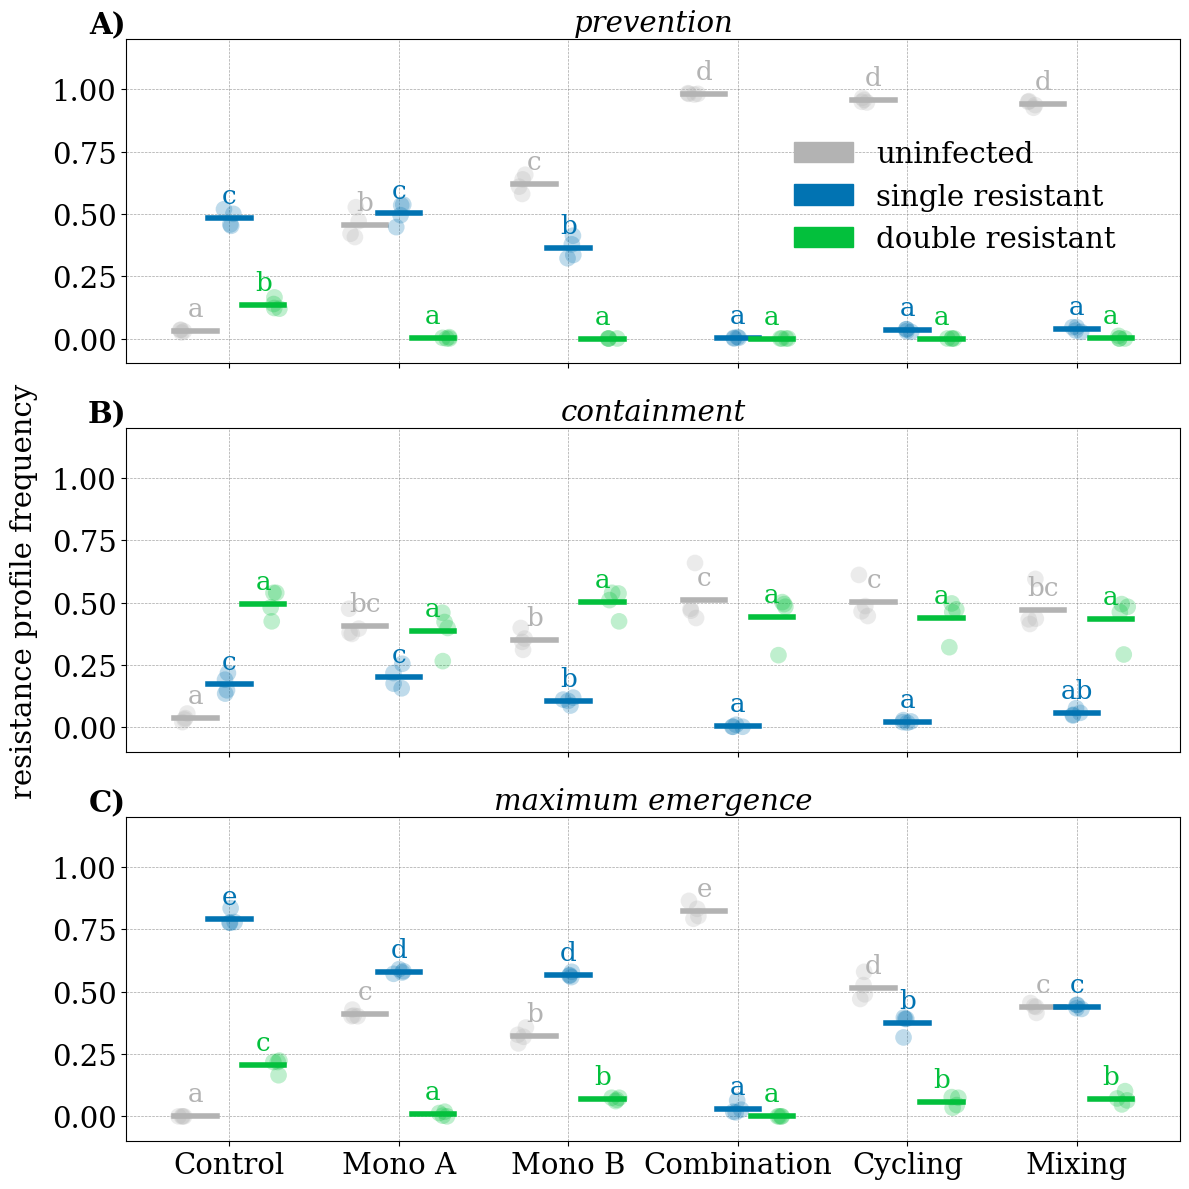

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

fontsize=21
dy = .04
line_length = 0.25  # Adjust the length of the line (in axis units)
# Ensure the correct strategy order is used when plotting
strategy_order = list(exp.strategies)  # Make sure this order is consistent


# Create the FacetGrid with sharex=True
g = sns.FacetGrid(summary_df, row="date", height=4, aspect=3, sharex=False)

# Plot the stripplot
g.map(sns.stripplot, 
      "strategy", 
      "value", 
      "label", 
      s=12,
      dodge=.25, 
      palette=color_dict, 
      alpha=0.25, 
      hue_order=color_dict.keys(), 
      order=strategy_order)


# Get x-ticks from the last plot (for consistency across all plots)
xticks = g.axes.flat[-1].get_xticklabels()
xticks = [tick.get_text() for tick in xticks]

# Annotate significance letters
for i, ax in enumerate(g.axes.flat):


    date = ax.get_title().split(' = ')[-1]
    for strategy in strategy_order:
        for i, label in enumerate(labels):
            data = grouped_df.loc[(date, strategy, label)]
            mean_value = data['mean']
            letter = data['letters']
            # Find the x-position from the actual tick labels
            if strategy in xticks:
                x_pos = xticks.index(strategy)
                dodge_offset = (i - (len(labels) - 1) / 2) * 0.2  # Adjust for dodge      
                # Annotate the plot with the significance letter
                ax.text(x_pos + dodge_offset, mean_value + dy, letter, 
                        ha='center', va='bottom', fontsize=fontsize*.9, color=color_dict[label], fontfamily = "serif")
                # Draw a short horizontal line for the mean
                
                ax.plot([x_pos + dodge_offset - line_length / 2, x_pos + dodge_offset + line_length / 2],
                        [mean_value, mean_value],
                        color=color_dict[label], linestyle='-', linewidth=linewidth)




# Remove the x-tick labels for ax[0] and ax[1]
g.axes[0, 0].set_xticklabels([])
g.axes[1, 0].set_xticklabels([])
g.axes[2, 0].set_xticklabels(xticks)

# Adjust y-ticks and gridlines for every 0.25 steps
for ax in g.axes.flat:
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))  # Gridlines at every 0.25 step


# Adjust y-labels and x-labels
g.axes[0, 0].set_ylabel(None)
g.axes[2, 0].set_ylabel(None)
g.axes[2, 0].set_xlabel(None)
g.axes[1, 0].set_ylabel("resistance profile frequency", fontsize = style["rcParams"]["font.size"])


titles = ("prevention", "containment", "maximum emergence") 
annotations = ["A)", "B)", "C)"] 
for ax, title, letter in zip(g.axes.flat, titles, annotations):
    ax.set_title(title, style = "italic", fontsize = fontsize)
    ax.set_ylim([-.1, 1.2])
    
    xticks = ax.get_xticks()
    xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
    new_labels = ["Control" if label == "No treatment" else label for label in xtick_labels]
    ax.set_xticklabels(new_labels)
    
    figure.reset_rcParams()
    figure.format_frame(ax)
    figure.format_ticks(ax, fontsize = fontsize)
    figure.format_labels(ax, fontsize = fontsize)
    figure.format_title(ax, fontsize = fontsize)
    
    add_panel_letter(ax, letter, fontsize = fontsize, fontfamily = "serif")


# Add the legend and customize the labels
# Create custom legend handles (colored boxes with alpha=1)
handles = [mpatches.Patch(color=color_dict["U_mean"], label="uninfected", ),
           mpatches.Patch(color=color_dict["single_resistant_mean"], label="single resistant"),
           mpatches.Patch(color=color_dict["double_resistant_mean"], label="double resistant")]

# Add the custom legend with colored boxes
g.fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.8, 0.9), 
             ncol=1, frameon=False, prop={'size': fontsize, "family":"serif"})

plt.tight_layout()
g.fig.subplots_adjust(hspace=0.2)  # Adjust vertical spacing (hspace)


figure.save_figure("end_anova")
plt.show()



In [ ]:
style["rcParams"]["legend.fontsize"]